## Полезные ссылки и литература

#### Этот блокнот основан на посте:
https://github.com/msurtsukov/ae_vae_gan/blob/master/manifold_and_latent.ipynb  
Можно сказать что это репост кода + некая творческай постобработка.

#### Литература и ссылки из поста:
Тот пост в свою очередь основан на главе про автоэнкодеры (в частности подглавы *Learning maifolds with autoencoders*) в *Deep Learning Book*:  
http://www.deeplearningbook.org/contents/autoencoders.html  

## Manifold learning

Для того, чтобы лучше понимать как работают автоэнкодеры, а так же чтобы в последствии генерировать из кодов что-то новое, стоит разобраться в том, что такое коды и как их можно интерпретировать.

Наши изображения цифр это элементы 28*28=784-мерного пространства, как и вообще любое монохромное изображение 28 на 28.
Однако среди всех изображений, изображения цифр занимают лишь ничтожную часть, абсолютное же большинство изображений это просто шум. 
С другой стороны, если вязть произвольное изображение цифры, то и все изображения из некоторой окрестности так же можно считать цифрой. С некоторыми немного более жесткими аргументами мы можем видеть, что они занимают подпространство более низкого измерения.

Если взять два произвольных изображения цифры, то в изначальном 784-мерном пространстве скорее всего можно найти непрерывную кривую, все точки вдоль которой можно так же считать цифрами (хотя бы изображений цифр одного лейбла), а вкупе с прерыдущим замечанием, то и все точки некоторой области вдоль этой кривой.

Таким образом в пространстве всех изображений есть некоторое подпространство меньшей размерности в области вокруг которого сосредоточились изображения цифр. То есть, если наша генеральная совокупность это все изображения цифр, которые могут быть нарисованы впринципе, то плотность вероятности встретить такую цифру в пределах области сильно выше, чем вне.

Одной из популярных теорий среди исследователей машинного обучения является **гипотеза многообразия** (manifold hypothesis) : **MNIST — это низкоразмерное многообразие, проходящее и изгибающееся в своем многомерном пространстве вложений**. Другая гипотеза, больше связанная с топологическим анализом данных, заключается в том, что **данные, подобные MNIST, состоят из пятен с выступами, похожими на щупальца, торчащими в окружающее пространство**.


Автоэнкодеры с размерностью кода k ищут k-мерное многообразие в пространстве объектов, которое наиболее полно передает все вариации в выборке. А сам код задает параметризацию этого многообразия. При этом энкодер сопоставляет объекту его параметр на многообразии, а декодер параметру сопоставляет точку в пространстве объектов.

Чем больше размерность кодов, тем больше вариаций в данных автоэнкодер сможет передать. Если размерность кодов слишком мала, автоэнкодер запомнит нечто среднее по недостающим вариациям в заданной метрике (это одна из причин, почему *mnist* цифры все более размытые при снижении размерности кода в автоэнкодерах).

In [44]:
%load_ext autoreload
%autoreload 2

In [72]:
# Импорт необходимых библиотек
from itertools import cycle
import datetime

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
import scipy.stats as stats

import tensorflow as tf
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import L1L2

from data.get_data import get_mnist
from visualization.plot_graph import plot_digits, plot_homotopy

%matplotlib inline

### Простые примеры

Для того, чтобы лучше понять что такое ***manifold learning***, создадим простой двумерный датасет в виде кривой плюс шум и будем обучать на нем автоэнкодер

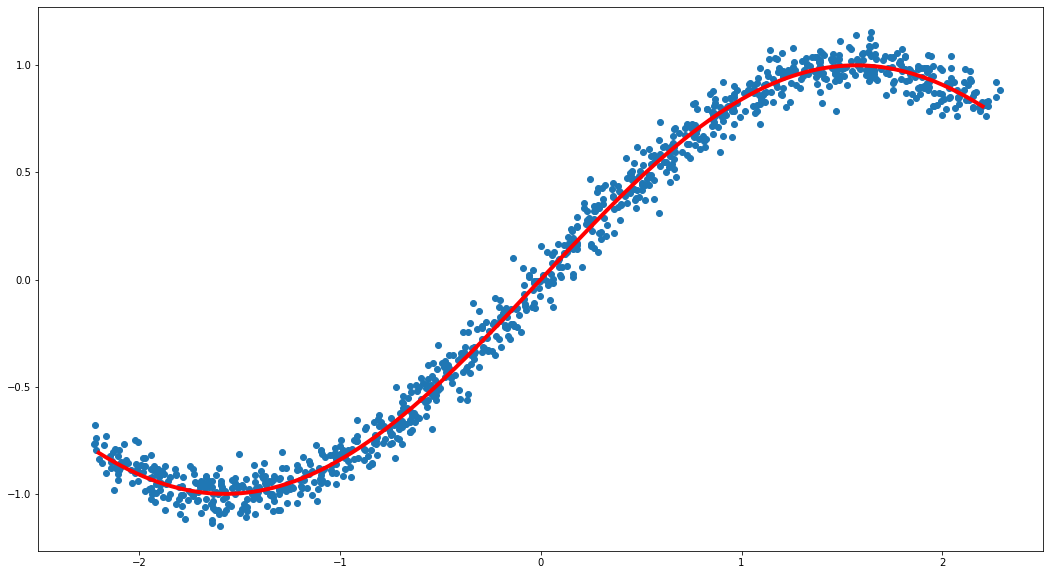

In [11]:
# Создание датасета
x1 = np.linspace(-2.2, 2.2, 1000)
fx = np.sin(x1)
dots = np.vstack([x1, fx]).T
noise = 0.06 * np.random.randn(*dots.shape)
dots += noise

# Цветные точки для отдельной визуализации позже
size = 25
colors = ["r", "g", "c", "y", "m"]
idxs = range(0, x1.shape[0], x1.shape[0]//size)
vx1 = x1[idxs]
vdots = dots[idxs]

# Визуализация
plt.figure(figsize=(18, 10))
plt.xlim([-2.5, 2.5])
plt.scatter(dots[:, 0], dots[:, 1])
plt.plot(x1, fx,  color="red", linewidth=4)
plt.grid(False)


На картинке выше синие точки - данные, а красная кривая - многообразие определяющее наши данные

#### Линейный сжимающий автоэнкодер (PCE)

Самый простой автоэнкодер - это двухслойный сжимающий автоэнкодер с линейными функциями активации (больше слоев не имеет смысла при линейной активации).

Такой автоэнкодер ищет аффинное (линейное со сдвигом) подпространство в пространстве объектов, которое описывает наибольшую вариацию в объектах, тоже самое делает и ***PCA*** (метод главных компонент) и оба они находят одно и тоже подпространство

In [7]:
def linear_ae():
    input_dots = Input((2,))
    code = Dense(1, activation='linear')(input_dots)
    out  = Dense(2, activation='linear')(code)

    ae = Model(input_dots, out)
    return ae

ae = linear_ae()
ae.compile(Adam(0.01), 'mse')

print(ae.summary())

ae.fit(dots, dots, epochs=15, batch_size=30, verbose=0)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
 dense_1 (Dense)             (None, 2)                 4         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
# Применение линейного автоэнкодера
pdots = ae.predict(dots, batch_size=30)
vpdots = pdots[idxs]

# Применения PCA
pca = PCA(1)
pdots_pca = pca.inverse_transform(pca.fit_transform(dots))

34/34 [==============================] - 0s 2ms/step


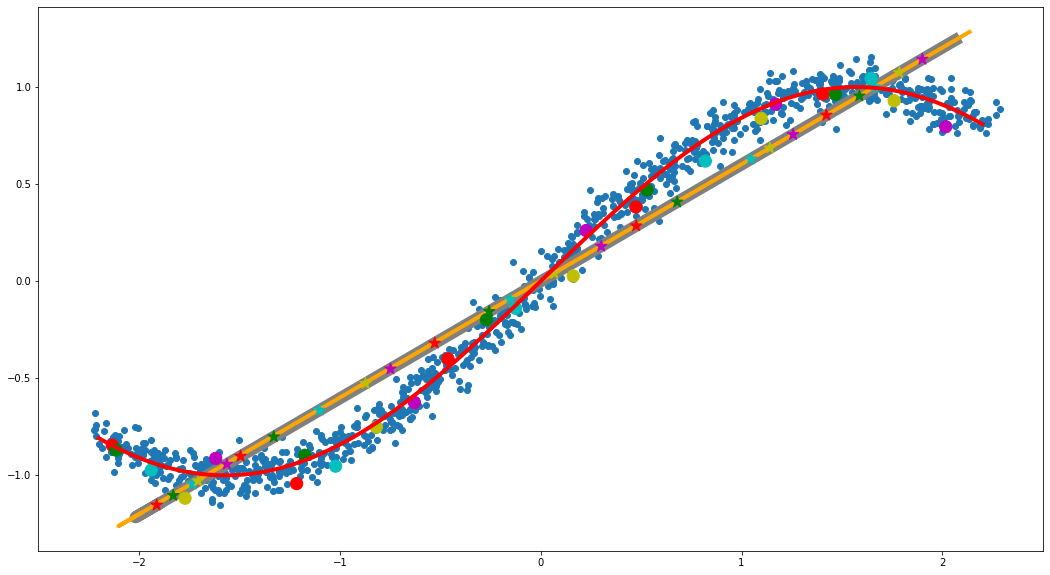

In [13]:
# Визуализация
plt.figure(figsize=(18, 10))
plt.xlim([-2.5, 2.5])

plt.scatter(dots[:, 0], dots[:, 1], zorder=1)
plt.plot(x1, fx,  color="red", linewidth=4, zorder=10)
plt.plot(pdots[:,0], pdots[:,1], color='grey', linewidth=12, zorder=3)
plt.plot(pdots_pca[:,0], pdots_pca[:,1], color='orange', linewidth=4, zorder=4)

plt.scatter(vpdots[:,0], vpdots[:,1], color=colors*5, marker='*', s=150, zorder=5)
plt.scatter(vdots[:,0], vdots[:,1], color=colors*5, s=150, zorder=6)
plt.grid(False)


На картинке выше:
* серая линия - многообразие в которое переходят синие точки данных после автоэнкодера,
то есть попытка автоэнкодера построить многообразие, определяющее больше всего вариации в данных
* оранжевая линия - многообразие в которое переходят синие точки данных после PCA
* разноцветные кружки - точки, которые переходят в зведочки соответствующего цвета после автоэнкодера
* разноцветные звездочки - соответственно образы кружков после автоэнкодера

Автоэнкодер ищущий линейные зависимости может быть не так полезен, как автоэнкодер, который может находить произвольные зависимости в данных. Полезно было бы, если и энкодер и декодер могли аппроксимизировать произвольные функции. Если добавить и в энкодер и в декодер еще хотя бы по одному слою достаточного размера и нелинейную функцию активации между ними, то они смогут находить произвольные зависимости

### Глубокий автоэнкодер

У глубокого автоэнкодера больше число слоев и самое главное - нелинейная функция активации между ними (в нашем случае *ELU* - Exponential Linear Unit)

In [14]:
def deep_ae():
    input_dots = Input((2,))
    x = Dense(64, activation='elu')(input_dots)
    x = Dense(64, activation='elu')(x)
    code = Dense(1, activation='linear')(x)
    x = Dense(64, activation='elu')(code)
    x = Dense(64, activation='elu')(x)
    out = Dense(2, activation='linear')(x)

    ae = Model(input_dots, out)
    return ae

dae = deep_ae()
dae.compile(Adam(0.003), 'mse')

print(dae.summary())


dae.fit(dots, dots, epochs=200, batch_size=30, verbose=0)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 64)                192       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
 dense_5 (Dense)             (None, 64)                128       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 2)                 130 

34/34 [==============================] - 0s 3ms/step


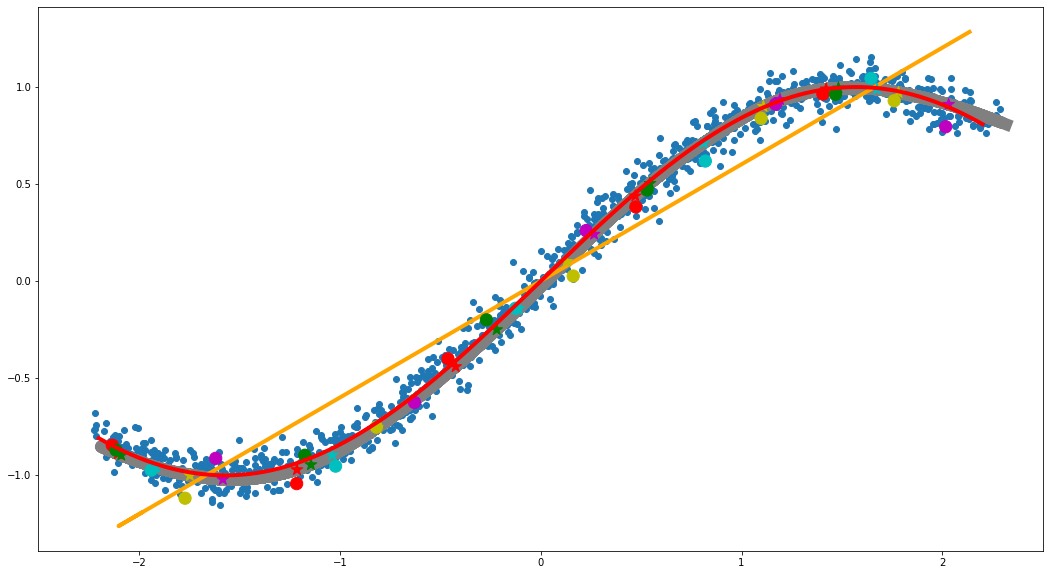

In [15]:
pdots_d = dae.predict(dots, batch_size=30)
vpdots_d = pdots_d[idxs]

# Визуализация
plt.figure(figsize=(18, 10))
plt.xlim([-2.5, 2.5])

plt.scatter(dots[:, 0], dots[:, 1], zorder=1)
plt.plot(x1, fx,  color="red", linewidth=4, zorder=10)

plt.plot(pdots_d[:,0], pdots_d[:,1], color='grey', linewidth=12, zorder=3)
plt.plot(pdots_pca[:,0], pdots_pca[:,1], color='orange', linewidth=4, zorder=4)

plt.scatter(vpdots_d[:,0], vpdots_d[:,1], color=colors*5, marker='*', s=150, zorder=5)
plt.scatter(vdots[:,0], vdots[:,1], color=colors*5, s=150, zorder=6)
plt.grid(False)

У такого автоэнкодера практически идеально получилось построить определяющее многообразие:
белая кривая почти совпадает с красной


#### Глубокий автоэнкодер в 784-мерном пространстве

Глубокий автоэнкодер теоретически сможет найти многообразие произвольной сложности, например такое, около которого лежат цифры в 784-мерном пространстве  

Вернемся к датасету рукописных цифр из предыдущей части, и к сверточной модели автоэнкодера.

**Общая схема**  
![](pics/01_autoencoders_c_autoencoder_0.png)

**Encoder**  
![](pics/01_autoencoders_c_autoencoder_1.png)

**Decoder**  
![](pics/01_autoencoders_c_autoencoder_2.png)

In [20]:
x_train, y_train, x_test, y_test = get_mnist()

# Сверточный автоэнкодер
def create_deep_conv_ae():
    input_img = Input(shape=(28, 28, 1))

    x = Conv2D(128, (7, 7), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (7, 7), activation='relu', padding='same')(x)

    # На этом моменте представление  (7, 7, 1) т.е. 49-размерное

    input_encoded = Input(shape=(7, 7, 1))
    x = Conv2D(32, (7, 7), activation='relu', padding='same')(input_encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (2, 2), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(x)

    # Модели
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder


c_encoder, c_decoder, c_autoencoder = create_deep_conv_ae()
c_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

c_autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 1)           24385     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         24385     
                                                                 
Total params: 48,770
Trainable params: 48,770
Non-trainable params: 0
_________________________________________________________________


In [23]:
%%time

# For tensorboard
log_dir = "logs/fit/02_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

c_autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[tensorboard_callback]
                )

Epoch 1/50
235/235 [==============================] - 25s 81ms/step - loss: 0.1809 - val_loss: 0.1013
Epoch 2/50
235/235 [==============================] - 18s 79ms/step - loss: 0.0949 - val_loss: 0.0887
Epoch 3/50
235/235 [==============================] - 18s 78ms/step - loss: 0.0870 - val_loss: 0.0831
...
Epoch 48/50
235/235 [==============================] - 18s 78ms/step - loss: 0.0702 - val_loss: 0.0696
Epoch 49/50
235/235 [==============================] - 18s 79ms/step - loss: 0.0700 - val_loss: 0.0696
Epoch 50/50
235/235 [==============================] - 18s 78ms/step - loss: 0.0701 - val_loss: 0.0697
Wall time: 15min 26s


Если взять два объекта и посмотреть на объекты лежащие на произвольной кривой между ними, то скорее всего промежуточные объекты не будут принадлежать генеральной совокупности, т. к. многообразие на котором лежит генеральная совокупность может быть сильно искривленным и малоразмерным

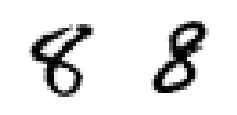

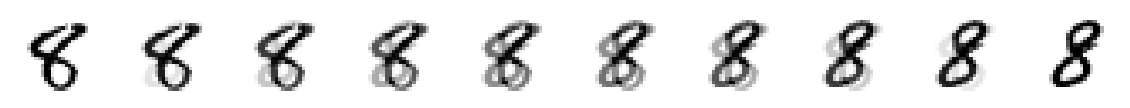

In [47]:
# Гомотопия по прямой в пространстве объектов
# Простой морфинг между объектами MNIST

frm, to = x_test[y_test == 8][1:3]

plot_digits(x_test[y_test == 8][1:3])
plot_homotopy(frm, to)

Если же двигаться по кривой между кодами (и если многообразие кодов хорошо параметризовано), то декодер переведет эту кривую из пространства кодов, в кривую не покидающую определяющее многообразие в пространстве объектов. То есть промежуточные объекты на кривой будут принадлежать генеральной совокупности

1/1 [==============================] - 0s 18ms/step


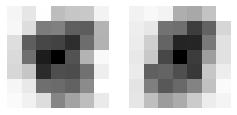

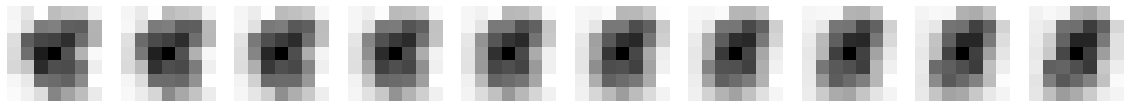

1/1 [==============================] - 0s 26ms/step


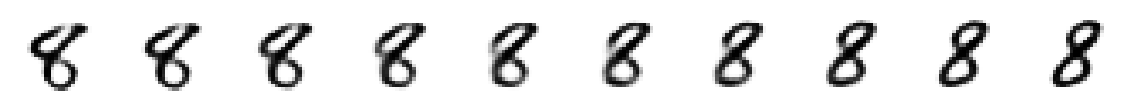

In [49]:
# Гомотопия по прямой в пространстве кодов
# Морфинг кодов, которые потом декодируются через декодер

# Коды
codes = c_encoder.predict(x_test[y_test == 8][1:3])
plot_digits(codes)

# Гомотопия по прямой в пространстве объектов
plot_homotopy(codes[0], codes[1], n=10)

# Гомотопия по прямой в пространстве кодов
plot_homotopy(codes[0], codes[1], n=10, decoder=c_decoder)

Промежуточные цифры - вполне себе хорошие восьмерки

Таким образом можно сказать, что автоэнкодер, по крайней мере локально, выучил форму определяющего многообразия

Но если попробовать сделать переход между двумя разными цифрами, то картина получится не такая красивая, т.к. между цифрами не существует "плавного перехода". Более подробно об этом рассмотрено в следующих статьях, про VAE (ConditionalVAE)

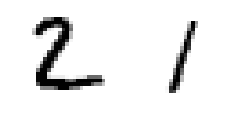

1/1 [==============================] - 0s 19ms/step


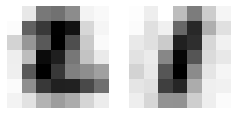

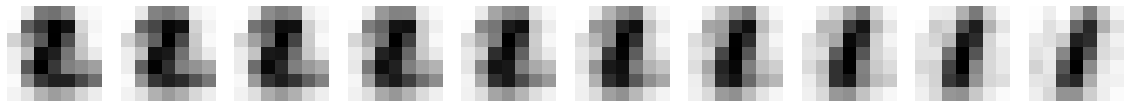

1/1 [==============================] - 0s 18ms/step


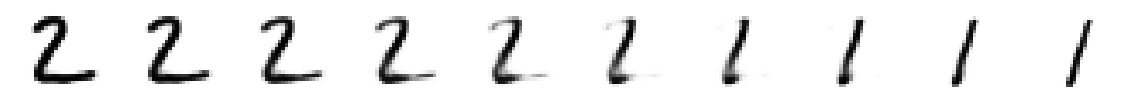

In [89]:
# Гомотопия по прямой в пространстве кодов
# Морфинг кодов, которые потом декодируются через декодер

# Коды

frm, to = x_test[1:3]
plot_digits(x_test[1:3])

codes = c_encoder.predict(x_test[1:3])
plot_digits(codes)

# Гомотопия по прямой в пространстве объектов
plot_homotopy(codes[0], codes[1], n=10)

# Гомотопия по прямой в пространстве кодов
plot_homotopy(codes[0], codes[1], n=10, decoder=c_decoder)

### Переобучение автоэнкодера

Для того, чтобы автоэнкодер мог научиться вычленять какие-то сложные закономерности, обобщающие способности энкодера и декодера должны быть ограничены, иначе даже автоэнкодер с одномерным кодом сможет просто провести одномерную кривую через каждую точку в обучающей выборке, т.е. просто запомнить каждый объект. Но это сложное многообразие, которое построит автоэнкодер не будет иметь много общего с определяющим генеральную совокупность многообразием

Возьмем ту же задачу с искуственными данными, обучим тот же глубокий автоэнкодер на очень маленьком подмножестве точек и посмотрим на получившееся многообразие

In [50]:
dae = deep_ae()
dae.compile(Adam(0.0003), 'mse')

# размножим 25 точек dots[idxs] из полного списка точек 
# до 100 000 значений, чтобы обеспечить переобучение на 25 точках
x_train_oft = np.vstack([dots[idxs]]*4000)

dae.fit(x_train_oft, x_train_oft, epochs=200, batch_size=15, verbose=1)

Epoch 1/200
6667/6667 [==============================] - 44s 6ms/step - loss: 0.0112
Epoch 2/200
6667/6667 [==============================] - 46s 7ms/step - loss: 0.0026
Epoch 3/200
6667/6667 [==============================] - 43s 6ms/step - loss: 0.0015
...
Epoch 198/200
6667/6667 [==============================] - 40s 6ms/step - loss: 3.2774e-05
Epoch 199/200
6667/6667 [==============================] - 40s 6ms/step - loss: 3.1636e-05
Epoch 200/200
6667/6667 [==============================] - 40s 6ms/step - loss: 3.1159e-05


34/34 [==============================] - 0s 3ms/step


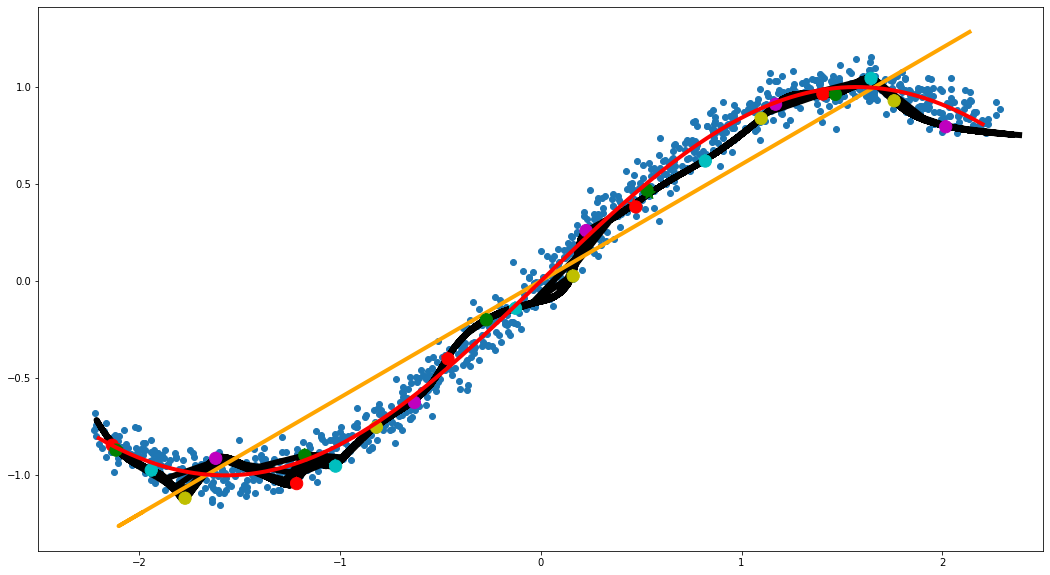

In [64]:
pdots_d = dae.predict(dots, batch_size=30)
vpdots_d = pdots_d[idxs]

plt.figure(figsize=(18, 10))
plt.xlim([-2.5, 2.5])

plt.scatter(dots[:, 0], dots[:, 1], zorder=1)
plt.plot(x1, fx,  color="red", linewidth=4, zorder=10)

plt.plot(pdots_d[:,0], pdots_d[:,1], color='black', linewidth=6, zorder=3)
plt.plot(pdots_pca[:,0], pdots_pca[:,1], color='orange', linewidth=4, zorder=4)

plt.scatter(vpdots_d[:,0], vpdots_d[:,1], color=colors*5, marker='*', s=150, zorder=5)
plt.scatter(vdots[:,0], vdots[:,1], color=colors*5, s=150, zorder=6)

plt.grid(False)

Видно, что черная кривая прошла через каждую точку данных и слабо похожа на определяющую данные красную кривую: на лицо типичное переобучение

## Скрытые переменные

Можно рассмотреть генеральную совокупность как некоторый процесс генерации данных $X$, который зависит от некоторого количества скрытых переменных $Z$ (случайных величин). Размерность данных $X$ может быть намного выше, чем размерность скрытых случайных величин $Z$, которые эти данные определяют. Рассмотрим процесс генерации очередной цифры:
то, как будет выглядеть цифра, может зависеть от множества факторов:
- желаемой цифры,
- толщины штриха,
- наклона цифры,
- аккуратности,
- и т.д.

Каждый из этих факторов имеет свое априорное распределение, например вероятность того, что будет нарисована восьмерка это распределение Бернулли с вероятностью 1/10, толщина штриха тоже имеет некоторое свое распределение и может зависеть как от аккуратности, так и от своих скрытых переменных, таких как толщина ручки или темперамент человека (опять же со своими распределениями)

Автоэнкодер сам в процессе обучения должен прийти к скрытым факторам, например таким как перечисленые выше,
каким-то их сложным комбинациям, или вообще к совсем другим. Однако, то совместное расределение, которое он выучит
вовсе не обязано быть простым, это может быть какая-то сложная кривая область. (Декодеру можно передать и значения извне этой области, вот только результаты уже не будут из определяющего многообразия, а из его случайного непрерывного продолжения)

Именно поэтому мы не можем просто генерировать новые $X$ из распределения этих скрытых переменных. Сложно оставаться
в пределах области, а еще сложнее как-то интепретировать значения скрытых переменных в этой кривой области.

Для определенности введем некоторые обозначения на примере цифр:
- $X$ - случайная величина картинки 28х28,
- $Z$ - случайная величина скрытых факторов, определяющих цифру на картинке, 
- $p(X)$ - вероятностное распределение изображений цифр на картинках, т.е. вероятность конкретного изображения цифры впринципе быть нарисованым (если картинка не похожа на цифру, то эта вероятность крайне мала),
- $p(Z)$ - вероятностное распределение скрытых факторов, например, распределение толщины штриха,
- $p(Z|X)$ - распределение вероятности скрытых факторов при заданной картинке (к одной и той же картинке могут привезти различное сочетание скрытых переменных и шума),
- $p(X|Z)$ - распределение вероятности картинок при заданных скрытых факторах, одни и те же факторы могут привезти к разным картинкам (один и тот же человек в одних и тех же условиях не рисует абсолютно одинаковые цифры),
- $p(X,Z)$ - совместное распределение $X$ и $Z$, наиболее полное понимание данных, необходимое для генерации новых объектов
  
  
$$p(X,Z) = p(X|Z) p(Z)$$
$p(X|Z)$ нам приближает декодер, но p(Z) на данный момент мы пока еще не понимаем  
  

**Посмотрим, как распределены скрытые переменные в обычном автоэнкодере**. 
Возмем глубокий автоэнкодер из первого блокнота.

Использовался в качестве базы глубокий автоэнкодер.
Кол-во слоев и размерности: 784 -> 64 -> 48 -> 32 -> 16. И слой кодирования - всего 16 нейронов.       

**Encoder**  
![](pics/02_manifold_learning_ae_0_1.png)

**Decoder**  
![](pics/02_manifold_learning_ae_0_2.png)

In [83]:
def create_deep_sparse_ae(lambda_l1):
    # Размерность кодированного представления
    encoding_dim = 16

    # Энкодер
    input_img = Input(shape=(28, 28, 1))
    flat_img = Flatten()(input_img)
    x = Dense(encoding_dim*4, activation='relu')(flat_img)
    x = Dense(encoding_dim*3, activation='relu')(x)
    x = Dense(encoding_dim*2, activation='relu')(x)
    encoded = Dense(encoding_dim, activation='linear', activity_regularizer=L1L2(lambda_l1, 0))(x)
    
    # Декодер
    input_encoded = Input(shape=(encoding_dim,))
    x = Dense(encoding_dim*2, activation='relu')(input_encoded)
    x = Dense(encoding_dim*3, activation='relu')(x)
    x = Dense(encoding_dim*4, activation='relu')(x)
    flat_decoded = Dense(28*28, activation='sigmoid')(x)
    decoded = Reshape((28, 28, 1))(flat_decoded)
    
    # Модели
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

# ======================================================================

encoder, decoder, autoencoder = create_deep_sparse_ae(0.)
autoencoder.compile(optimizer=Adam(0.0003), loss='binary_crossentropy')

autoencoder.save("./models/02.0_manifold_learning_autoencoder_01.h5", save_format="h5")

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                55456     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         56224     
                                                                 
Total params: 111,680
Trainable params: 111,680
Non-trainable params: 0
_________________________________________________________________


In [84]:
%%time

# For tensorboard
log_dir = "logs/fit/02_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[tensorboard_callback]
)


Epoch 1/200
235/235 [==============================] - 6s 20ms/step - loss: 0.3490 - val_loss: 0.2552
Epoch 2/200
235/235 [==============================] - 4s 18ms/step - loss: 0.2317 - val_loss: 0.2058
...
Epoch 199/200
235/235 [==============================] - 2s 10ms/step - loss: 0.1010 - val_loss: 0.1004
Epoch 200/200
235/235 [==============================] - 2s 10ms/step - loss: 0.1010 - val_loss: 0.1003
Wall time: 7min 50s


Вот так выглядят восстановленные этим энкодером изображения:

1/1 [==============================] - 0s 26ms/step


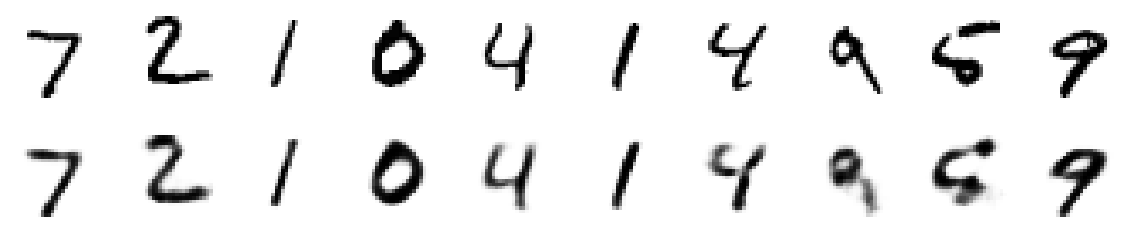

In [87]:
n = 10
imgs = x_test[:n]
decoded_imgs = autoencoder.predict(imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)

Совместное распределение скрытых переменных $P(Z_1, Z_3)$ - совместное распределение переменных 1 и 3 значения из 16 кодированных значений

313/313 [==============================] - 1s 2ms/step


d:\9-GitHubR\gh_mnist_experiments\mnist_experiments\.venv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


R2: -0.39 p_val: 0.0


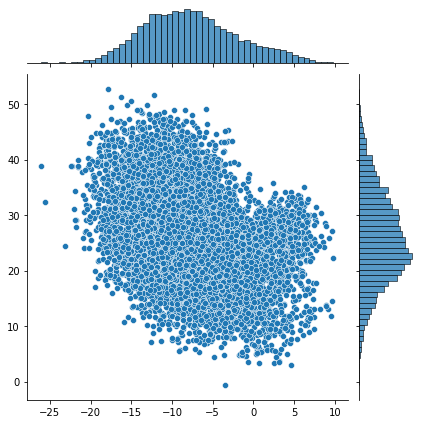

In [88]:
codes = encoder.predict(x_test)

sns.jointplot(codes[:,1], codes[:,3]) #, kind="hist")

r, p = stats.pearsonr(codes[:,1], codes[:,3])
print("R2:", np.round(r,2), "p_val:", np.round(p,4))


Видно, что совместное распределение $p(Z_1,Z_3)$ имеет сложную форму; $Z_1$ и $Z_3$ немного зависимы друг от друга  
  
Есть ли какой-то способ контролировать распределения скрытых переменных P(Z)?  

Самый простой способ - добавить регуляризатор $L_1$ или $L_2$ на значения $Z$, это добавит априорные предположения на распределения скрытых переменных, соответственно лапласса или нормальное (похоже на априорное распределение добавляемое на значения весов при регуляризации). Регуляризатор вынуждает автоэнкодер искать скрытые переменные, которые распределены по нужным законам, получится ли у него - другой вопрос. Однако это никак не заставляет делать их независимыми, т.е. $p(Z_i) \neq p(Z_i|Z_j) $  
  
**Посмотрим на совместное распределение скрытых параметров в разреженом автоэнкодере**

In [56]:
s_encoder, s_decoder, s_autoencoder = create_deep_sparse_ae(0.00001)
s_autoencoder.compile(optimizer=Adam(0.0003), loss='binary_crossentropy')

s_autoencoder.save("./models/02.0_manifold_learning_s_autoencoder_02.h5", save_format="h5")
s_autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                55456     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         56224     
                                                                 
Total params: 111,680
Trainable params: 111,680
Non-trainable params: 0
_________________________________________________________________


In [57]:
%%time

# For tensorboard
log_dir = "logs/fit/02_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


s_autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[tensorboard_callback]
)


Epoch 1/200
235/235 [==============================] - 5s 17ms/step - loss: 0.3446 - val_loss: 0.2535
Epoch 2/200
235/235 [==============================] - 3s 14ms/step - loss: 0.2331 - val_loss: 0.2168
...
Epoch 199/200
235/235 [==============================] - 2s 10ms/step - loss: 0.1007 - val_loss: 0.1003
Epoch 200/200
235/235 [==============================] - 3s 11ms/step - loss: 0.1007 - val_loss: 0.1004
Wall time: 7min 45s


1/1 [==============================] - 0s 95ms/step


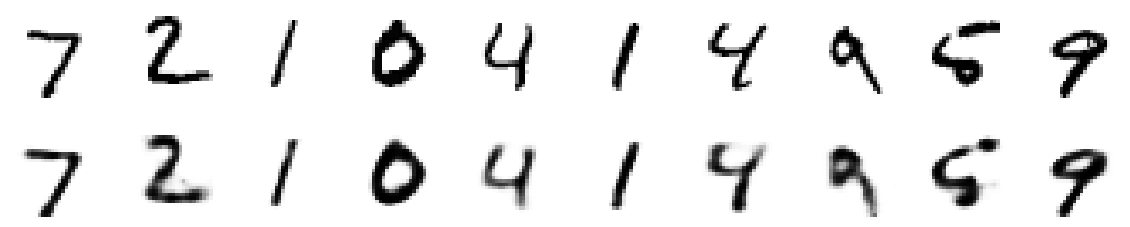

In [58]:
imgs = x_test[:n]
decoded_imgs = s_autoencoder.predict(imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)

313/313 [==============================] - 1s 2ms/step


d:\9-GitHubR\gh_mnist_experiments\mnist_experiments\.venv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


R2: 0.28 p_val: 0.0


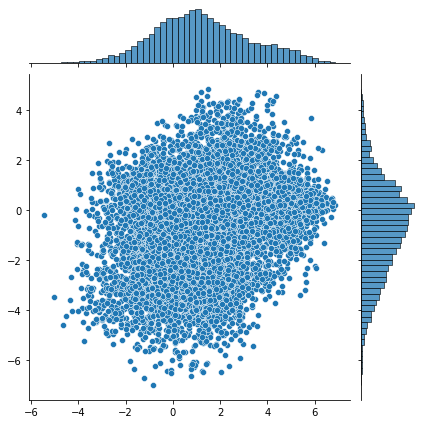

In [81]:
codes = s_encoder.predict(x_test)

sns.jointplot(codes[:,1], codes[:,3])

r, p = stats.pearsonr(codes[:,1], codes[:,3])
print("R2:", np.round(r,2), "p_val:", np.round(p,4))

$Z_1$ и $Z_3$ все так же зависимы друг от друга, но теперь хотя бы распределены вокруг 0 более нормально, чем в прошлом эксперименте.  
  
О том, как контролировать скрытое пространство, так, чтобы из него уже можно было осмысленно генерировать изображения - в следующей части про вариационные автоэнкодеры (VAE).